# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-885n7g2d
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-885n7g2d
  Resolved https://github.com/albumentations-team/albumentations to commit e50ae0f40962c21a66576d99c5c2e6768d7b8189
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers


### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

In this project we are going to do a segmentation task in which given an areial mage to this U-Net The U-Net will output the mask and in this mask image these segmented regions are going to be the roads
So the labels in this lask images are going to be roads


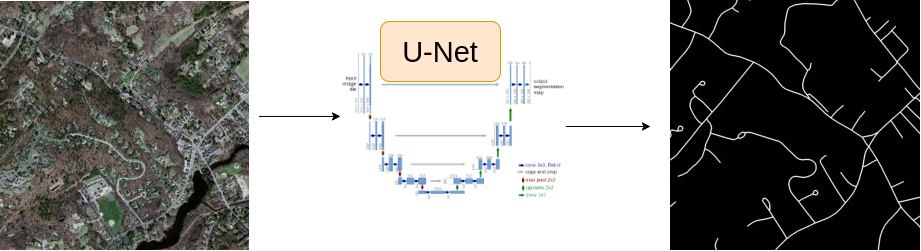

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations
just the variables and parameters that we are going to use throughout the project (remote control of the project)

In [5]:
CSV_FILE='/content/Road_seg_dataset/train.csv'
DATA_DIR='/content/Road_seg_dataset/'
DEVICE='cuda'
#'cuda' need google pro
EPOCHS =15
LR=0.003
BATCH_SIZE=8
IMG_SIZE=512
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'


In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


## In this
1.Written the Configuration
2.Successfully read some of the images from this train dot CSP using the images path and mask path
3.Then we have also pltted these both of these images ,the image and its ground truth
4.Then we have akso successfully splitting our dataset into training and validation dataframes

In [7]:
index=10
row=df.iloc[index]
image_path=DATA_DIR+row.images
mask_path=DATA_DIR+row.masks
#open cv read images in BGR format
#we are going to convert BGR to RGB
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255



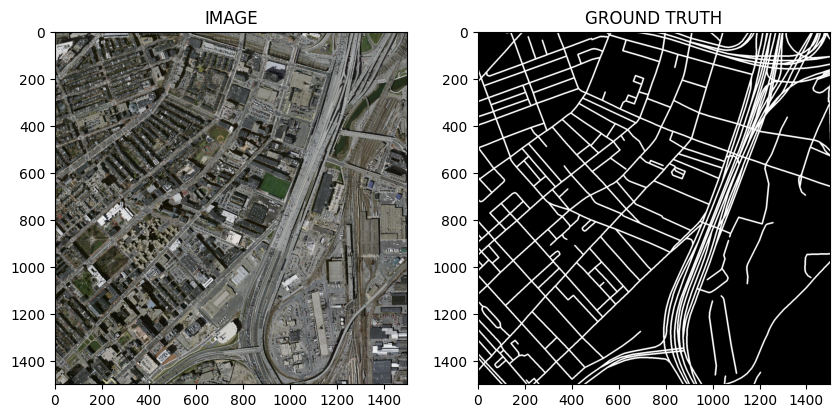

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
#split the dataset intro training and validation
train_df,val_df=train_test_split(df,test_size=0.2,random_state=45)

In [10]:
len(val_df)

40

In [11]:
len(train_df)

159

In [12]:
len(df)

199

# Task 3 : Augmentation Functions
Data Augmentation
for both training and validation set

In [13]:
import albumentations as A

albumentation documentation : https://albumentations.ai/docs/

In [14]:
def get_train_augmentations():
 return A.Compose([
     A.Resize(IMG_SIZE,IMG_SIZE),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)
 ])
 #when you do augmentation on the image the label is not going to change
#But when you do segmentaion the scenario is different when you will rotate the aerial image its mask should also rotate
#if you flip the aerial image its mask should also flip
#It is the reason why we are using this argumentation library
#apply this transformation son both mask and aerial image
def get_val_augmentations():
 return A.Compose([
     A.Resize(IMG_SIZE,IMG_SIZE),

 ])
# augmentation only done during training
#jus resigzing in the testing phase

# Task 4 : Create Custom Dataset

create the Custom Dataset which will return the image and its ground truth pair whenever we specify the index  ( same as before by index just now by class and method format to read the image and mask per given any index)

In [15]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):

    def __init__(self,df,augmentations):
        self.df=df
        self.augmentations=augmentations
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        row=self.df.iloc[index]
        image_path=DATA_DIR+row.images
        mask_path=DATA_DIR+row.masks
#open cv read images in BGR format
#we are going to convert BGR to RGB
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        #at this point the mask format will be in (H,W)
    #but we are going to add one extra dimension for the channel
        mask=np.expand_dims(mask,axis=-1) #(H,W,C)
    #Channel will be one as it is a grayscale image

 # if self augmentation true
        if self.augmentations:
            data=self.augmentations (image=image,mask=mask ) #extract our image and mask from dictionary format
      #key is image
            image=data['image'] #(H,W,C) C=Channel
            mask=data['mask']
      #We will have our augmented image and mask at this point

  #Pytorch is uses channel height and width convention
  #So whenever we are going to pass our image or mask per cell to the network ,our potential
  #Height and Width
  #We are going to convert from height with channel 2 Height and width convetion
  #Transpose
  #Height 2nd axis W 0axis C first axis
        image=np.transpose(image,(2,0,1)).astype(np.float32)#(C,H,W)
        mask=np.transpose(mask,(2,0,1)).astype(np.float32)#(C,H,W)
#Now it is Height Width COnvention
#Convert this Numpy array to torch tensor
        image=torch.Tensor(image)/255.0
        mask=torch.round(torch.Tensor(mask)/255.0)
        return image,mask


#Dataset class is ready

In [17]:
train_set=SegmentationDataset(train_df,get_train_augmentations())
valid_set=SegmentationDataset(val_df,get_val_augmentations())

In [18]:
len(train_set)

159

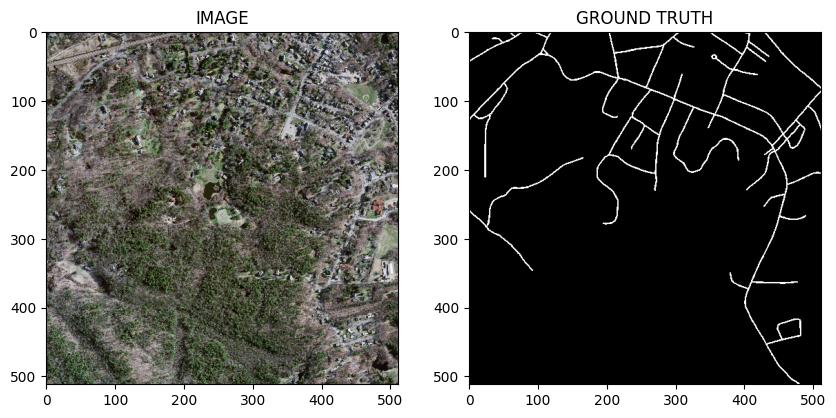

In [19]:
idx=21
image,mask=train_set[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
trainloader=DataLoader(train_set,batch_size=BATCH_SIZE ,shuffle=True)
validloader=DataLoader(valid_set,batch_size=BATCH_SIZE )

In [22]:
len(trainloader)

20

In [23]:
len(validloader)

5

In [24]:
for images,masks in trainloader :
  print(f'One Batch image shape:{images.shape}')
  print(f'One Batch mask shape:{masks.shape}')
  break;
  #as we only want the 1st batch we break
  #8 8 image tensors and 8 mask
  #1st batch, then channel then height and width
  #Successfully loaded data into batches using dataLoader

One Batch image shape:torch.Size([8, 3, 512, 512])
One Batch mask shape:torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [25]:
#LOAD a U-Net Architecture using a library called segmentation model Pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn


In [26]:
class SegmentationModel(nn.Module):
  def __init__(self):
     super(SegmentationModel,self).__init__()

     self.backbone=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
     )
  def forward(self,images,masks=None):
    logits=self.backbone(images)
    if masks !=None:
      return logits,DiceLoss(mode='binary')(logits,masks)+nn.BCEWithLogitsLoss()(logits,masks)
    return logits
    # you can try another loss function other than DiceLoss


In [27]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function
Train and Val Function
In train function we should first specify the model should be on training model
then gradient computation and the parameter computation part
We made sur the gradient is zero then we get the loss
after getting the loss we get the gradients (loss.backward)
once the gradient is calculated the optimizer.step will update the parameters that are the weights and the biases of the network
use both in the trainin lopp

In [28]:
def train_fn(dataloader,model,optimizer):
   model.train() #Trun on dropout,batchnorm,etc...
   total_loss=0.0
   for images,masks in tqdm(dataloader):
       images=images.to(DEVICE)
       masks=masks.to(DEVICE)
       optimizer.zero_grad()
       logits,loss=model(images,masks)
       loss.backward()
       optimizer.step()
       total_loss += loss.item()

   return total_loss / len(dataloader)

In [29]:
def eval_fn(dataloader,model):
  model.eval() #Trun off dropout,batchnorm,etc...
  #during dropout
  total_loss=0.0
  with torch.no_grad():
     for images,masks in tqdm(dataloader):
       images=images.to(DEVICE)
       masks=masks.to(DEVICE)
       logits,loss=model(images,masks)
       total_loss+=loss.item()

     return total_loss / len(dataloader)

# Task 8 : Train Model

In [30]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [31]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss=train_fn(trainloader, model,optimizer)
    valid_loss=eval_fn(validloader,model)

    if valid_loss < best_loss:
      torch.save(model.state_dict(),"best-model.pt")
      print("SAVED-MODEL")
      best_loss=valid_loss

    print(f"Epoch:{i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

  #first progression id for the train function
  #best validation loss model at around 21 epochs

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED-MODEL
Epoch:1 Train Loss: 1.0428464323282243 Valid Loss: 1.1878703117370606


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


SAVED-MODEL
Epoch:2 Train Loss: 0.7677469044923783 Valid Loss: 0.8410918593406678


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch:3 Train Loss: 0.7095216363668442 Valid Loss: 0.7106946706771851


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch:4 Train Loss: 0.6938039839267731 Valid Loss: 0.7327663421630859


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch:5 Train Loss: 0.6759418606758117 Valid Loss: 0.6704976797103882


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch:6 Train Loss: 0.6542148530483246 Valid Loss: 0.6649375200271607


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch:7 Train Loss: 0.6472804456949234 Valid Loss: 0.7035807609558106


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch:8 Train Loss: 0.6320172101259232 Valid Loss: 0.7205570220947266


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch:9 Train Loss: 0.640802600979805 Valid Loss: 0.8027702212333679


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch:10 Train Loss: 0.639473506808281 Valid Loss: 0.6826606512069702


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch:11 Train Loss: 0.6245489567518234 Valid Loss: 0.667240297794342


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch:12 Train Loss: 0.610936951637268 Valid Loss: 0.7141866326332093


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch:13 Train Loss: 0.6021371781826019 Valid Loss: 0.6555426478385925


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch:14 Train Loss: 0.6086011320352555 Valid Loss: 0.6042877852916717


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

Epoch:15 Train Loss: 0.5951074630022049 Valid Loss: 0.6305145382881164


# Task 9 : Inference
we are going to use the same best model.pe to segment the regions in the image

In [38]:
idx= 17
model.load_state_dict(torch.load('/content/best-model.pt')) #copy path of best model pt
image,mask = valid_set[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0)) #unsqueeze 0 gonna add an extra dimension
#(c,h,w)=>(b,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0
#from the helper file we are going to use show image function


<ipython-input-38-a80019547b5b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best-model.pt')) #copy path of best model pt


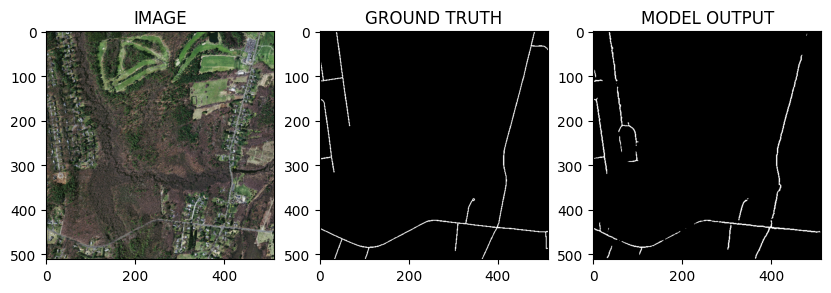

In [41]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

In [42]:
#ground truth and model output are somewhat similar
#there is less error between the ground turth and model output
#use the massachusets road dataset you have created custom dataset then you have loaded the dataset into batches through data model
# then you have also created the segmentation model using SNP
#SNP segmentation moel pytorch
#you have also implemented augmentation on the segmentation dataset
#then created the train and val function
#both of these function were very useful in the training loop
#finally we have used the sailed best model during the inference